### Exercise 2 - Web crawling using BeautifulSoup and text processing


In [7]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import numpy as np

### Exercise 2.1

#### 1. To avoid crawling the same page multiple times, we make sure that we consistently format all links discovered. For this purpose, the links are kept in a running set as the program is running. A set only stores unique elements. 

#### 2. To avoid the second pitfall of the web crawler, we can impose a condition on the number of links crawled from each page. For example, if the total number of pages to crawl is 10, we can restrict the number of links returned by each page from the seed page to 2.

In [2]:
#%% Find linked pages in Finnish sites, but not PDF or PS files
def getpageurls(webpage_parsed):
 # Find elements that are hyperlinks
    pagelinkelements=webpage_parsed.find_all('a')
    pageurls=[];
    for pagelink in pagelinkelements:
        pageurl_isok=1
        try:
            pageurl=pagelink['href']
        except:
            pageurl_isok=0
        if pageurl_isok==1:
            # Check that the url does NOT contain these strings
            if (pageurl.find('.pdf')!=-1)|(pageurl.find('.ps')!=-1):
                pageurl_isok=0
            # Check that the url DOES contain these strings
            if (pageurl.find('http')==-1)|(pageurl.find('.fi')==-1):
                pageurl_isok=0
        if pageurl_isok==1:
            pageurls.append(pageurl)
   
    return(pageurls)

In [8]:
#%% Get the text content of the page
def getpagetext(parsedpage):
    # Remove HTML elements that are scripts
    scriptelements=parsedpage.find_all('script')
    # Concatenate the text content from all table cells
    for scriptelement in scriptelements:
        # Extract this script element from the page.
        # This changes the page given to this function!
        scriptelement.extract()
    pagetext=parsedpage.get_text()
    return(pagetext)

In [3]:
crawled_urls = set() # stores the crawled urls
def basicwebcrawler(seedpage_url,maxpages):
    # Store URLs crawled and their text content
    num_pages_crawled=0
    #crawled_urls=[]
    global crawled_urls
    crawled_texts=[]
    # Remaining pages to crawl: start from a seed page URL
    pagestocrawl=[seedpage_url]
    # Process remaining pages until a desired number
    # of pages have been found
    while (num_pages_crawled<maxpages)&(len(pagestocrawl)>0):
        # Retrieve the topmost remaining page and parse it
        pagetocrawl_url=pagestocrawl[0]
        print('Getting page:')
        print(pagetocrawl_url)
        pagetocrawl_html=requests.get(pagetocrawl_url)
        pagetocrawl_parsed=BeautifulSoup(pagetocrawl_html.content,'html.parser')
        # Get the text and URLs of the page
        # we check if pagetocrawl_url is already crawled
        if pagetocrawl_url not in crawled_urls:
            pagetocrawl_text=getpagetext(pagetocrawl_parsed)
            pagetocrawl_urls=getpageurls(pagetocrawl_parsed)
            num_pages_crawled=num_pages_crawled+1
            crawled_urls.add(pagetocrawl_url)
            crawled_texts.append(pagetocrawl_text)
            pagestocrawl=pagestocrawl[1:len(pagestocrawl)]
            pagestocrawl.extend(pagetocrawl_urls)
            
    return(crawled_urls,crawled_texts, num_pages_crawled)


In [20]:
crawled_urls, crawled_texts, num_pages_crawled = basicwebcrawler('https://homepages.tuni.fi/jaakko.peltonen/', 10)

Getting page:
https://homepages.tuni.fi/jaakko.peltonen/
Getting page:
https://www.tuni.fi/en
Getting page:
https://www.tuni.fi/en/about-us/faculty-information-technology-and-communication-sciences
Getting page:
https://www.tuni.fi/en/about-us/computing-sciences
Getting page:
http://cs.aalto.fi/en/
Getting page:
http://www.cis.hut.fi/projects/mi
Getting page:
http://users.ics.aalto.fi/jtpelto/
Getting page:
http://research.ics.aalto.fi/coin/
Getting page:
https://www.tuni.fi/studentsguide/curriculum/degree-programmes/uta-tohjelma-1717?year=2019
Getting page:
https://www.tuni.fi/en/study-with-us/computing-sciences-data-science?navref=curated--list


In [21]:
crawled_texts

['\n\n\nJaakko Peltonen\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJaakko Peltonen\n\nI am a professor of statistics (data analysis) at Tampere University,\nFaculty \nof Information Technology and Communication Sciences, \nunit of Computing Sciences and \nthe statistical data analytics team within the unit.\n\n\nI am the leader of the \nStatistical Machine Learning and Exploratory Data Analysis (SMiLE) research group\nand a member of the \nAcademy of Finland Center of Excellence in Game Culture Studies.\n\n\nI am also a docent (adjunct professor) at Aalto University, \nwhere I have been a visiting professor at the \nDepartment of Computer Science,\nand where I have been a PI of the \nProbabilistic Machine Learning \nresearch group; I was previously an academy research fellow at the same department. \nI have a previous webpage at Aalto.\n\nI previously worked at University of Sheffield, \nSheffield Institute for Translational Neuroscience, \nwith Prof. \nMagnus Rattray and \nProf. Neil Lawrence. \nI 

In [22]:
crawled_urls

{'http://cs.aalto.fi/en/',
 'http://research.ics.aalto.fi/coin/',
 'http://users.ics.aalto.fi/jtpelto/',
 'http://www.cis.hut.fi/projects/mi',
 'https://homepages.tuni.fi/jaakko.peltonen/',
 'https://www.tuni.fi/en',
 'https://www.tuni.fi/en/about-us/computing-sciences',
 'https://www.tuni.fi/en/about-us/faculty-information-technology-and-communication-sciences',
 'https://www.tuni.fi/en/study-with-us/computing-sciences-data-science?navref=curated--list',
 'https://www.tuni.fi/studentsguide/curriculum/degree-programmes/uta-tohjelma-1717?year=2019'}

### Exercise 2.2

In [9]:
ebook_addresses = set() # stores unique ebook addresses
def top_k_downloaded_ebooks(seed_page_url, top_k):
    global ebook_addresses
    ebook_names = []
    num_downloaded_ebooks = 0
    downloaded_texts = []
    download_base_url = 'https://www.gutenberg.org/files/'
    seed_page_parsed = requests.get(seed_page_url)
    soup = BeautifulSoup(seed_page_parsed.content, 'html.parser')
    h2_tag = soup.find(id='books-last30')
    ol_tag = h2_tag.next_sibling.next_sibling
    for a_tag in ol_tag.find_all('a'):
        # find matching pattern for ebook name
        name_match = re.match(r'(.*)(\(\d+\))', a_tag.text)
        ebook_name = name_match.group(1).strip()
        # find matching pattern for ebook id
        id_match = re.match(r'/ebooks/(\d+)', a_tag.get('href'))
        ebook_id = id_match.group(1)
        # form download url of an ebook
        ebook_url = download_base_url + ebook_id + '/' + ebook_id + '-0.txt'
        # avoid downloading same text document multiple times
        if (ebook_url not in ebook_addresses) & (num_downloaded_ebooks < top_k):
            print('Downloading text file from:')
            print(ebook_url)
            ebook_page = requests.get(ebook_url)
            parsed_page = BeautifulSoup(ebook_page.content, 'html.parser')
            # get text from the ebook
            ebook_text = getpagetext(parsed_page)
            start_index = ebook_text.find('*** START OF THE PROJECT GUTENBERG EBOOK')
            end_index = ebook_text.find('*** END OF THE PROJECT GUTENBERG EBOOK')
            ebook_text = ebook_text[start_index:end_index]
            # remove leading and trailing whitespaces
            ebook_text = ebook_text.strip()
            ebook_text = ' '.join(ebook_text.split())
            # store book content
            downloaded_texts.append(ebook_text)
            ebook_addresses.add(ebook_url)
            ebook_names.append(ebook_name)
            num_downloaded_ebooks += 1
            
                
    return(downloaded_texts, ebook_names, ebook_addresses, num_downloaded_ebooks)
     

In [10]:
downloaded_texts, ebook_names, ebook_addresses, num_downloaded_ebooks = top_k_downloaded_ebooks(
    'https://www.gutenberg.org/browse/scores/top', 10)

https://www.gutenberg.org/files/84/84-0.txt
https://www.gutenberg.org/files/1342/1342-0.txt
https://www.gutenberg.org/files/25344/25344-0.txt
https://www.gutenberg.org/files/11/11-0.txt
https://www.gutenberg.org/files/345/345-0.txt
https://www.gutenberg.org/files/2701/2701-0.txt
https://www.gutenberg.org/files/2542/2542-0.txt
https://www.gutenberg.org/files/46/46-0.txt
https://www.gutenberg.org/files/174/174-0.txt
https://www.gutenberg.org/files/41/41-0.txt


In [11]:
ebook_names

['Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley',
 'Pride and Prejudice by Jane Austen',
 'The Scarlet Letter by Nathaniel Hawthorne',
 "Alice's Adventures in Wonderland by Lewis Carroll",
 'Dracula by Bram Stoker',
 'Moby Dick; Or, The Whale by Herman Melville',
 "A Doll's House : a play by Henrik Ibsen",
 'A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens',
 'The Picture of Dorian Gray by Oscar Wilde',
 'The Legend of Sleepy Hollow by Washington Irving']

In [8]:
ebook_addresses

{'https://www.gutenberg.org/files/1080/1080-0.txt',
 'https://www.gutenberg.org/files/11/11-0.txt',
 'https://www.gutenberg.org/files/1232/1232-0.txt',
 'https://www.gutenberg.org/files/1260/1260-0.txt',
 'https://www.gutenberg.org/files/1342/1342-0.txt',
 'https://www.gutenberg.org/files/1661/1661-0.txt',
 'https://www.gutenberg.org/files/174/174-0.txt',
 'https://www.gutenberg.org/files/1952/1952-0.txt',
 'https://www.gutenberg.org/files/25344/25344-0.txt',
 'https://www.gutenberg.org/files/2542/2542-0.txt',
 'https://www.gutenberg.org/files/2701/2701-0.txt',
 'https://www.gutenberg.org/files/345/345-0.txt',
 'https://www.gutenberg.org/files/408/408-0.txt',
 'https://www.gutenberg.org/files/41/41-0.txt',
 'https://www.gutenberg.org/files/43/43-0.txt',
 'https://www.gutenberg.org/files/46/46-0.txt',
 'https://www.gutenberg.org/files/5200/5200-0.txt',
 'https://www.gutenberg.org/files/64317/64317-0.txt',
 'https://www.gutenberg.org/files/84/84-0.txt',
 'https://www.gutenberg.org/files/

In [12]:
# Tokenize downloaded texts and change them to NLTK format
mydownloaded_nltk_texts = []
for k in range(len(downloaded_texts)):
    temp_tokenizedtext = nltk.word_tokenize(downloaded_texts[k])
    temp_nltktext = nltk.Text(temp_tokenizedtext)
    mydownloaded_nltk_texts.append(temp_nltktext)

In [13]:
mydownloaded_nltk_texts[9]

<Text: ...>

In [14]:
# Make all downloaded texts lowercase
mydownloaded_lowercase_texts = []
for k in range(len(mydownloaded_nltk_texts)):
    temp_lowercase_text = []
    for l in range(len(mydownloaded_nltk_texts[k])):
        lowercase_word = mydownloaded_nltk_texts[k][l].lower()
        temp_lowercase_text.append(lowercase_word)
    temp_lowercasetest = nltk.Text(temp_lowercase_text)
    mydownloaded_lowercase_texts.append(temp_lowercase_text)

In [15]:
mydownloaded_lowercase_texts[1][1567]

'bennet'

In [16]:
# Convert a POS tag for WordNet
def tagtowordnet(postag):
    wordnettag=-1
    if postag[0]=='N':
        wordnettag='n'
    elif postag[0]=='V':
        wordnettag='v'
    elif postag[0]=='J':
        wordnettag='a'
    elif postag[0]=='R':
        wordnettag='r'
    return(wordnettag)

In [17]:
# POS tag and lemmatize the loaded texts
# Download tagger and wordnet resources if you do not have them already
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# lemmatize downloaded texts
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatizetext(nltktexttolemmatize):
    # tag the text with POS tags
    taggedtext = nltk.pos_tag(nltktexttolemmatize)
    # lemmatize each word text
    lemmatizedtext = []
    for l in range(len(taggedtext)):
        # Lemmatize a word using the WordNet converted POS tag
        wordtolemmatize = taggedtext[l][0]
        wordnettag = tagtowordnet(taggedtext[l][1])
        if wordnettag != -1:
            lemmatizedword = lemmatizer.lemmatize(wordtolemmatize, wordnettag)
        else:
            lemmatizedword = wordtolemmatize
        # store the lemmatized word
        lemmatizedtext.append(lemmatizedword)
    return(lemmatizedtext)

mydownloaded_lemmatizedtexts = []
for k in range(len(mydownloaded_lowercase_texts)):
    lemmatizedtext = lemmatizetext(mydownloaded_lowercase_texts[k])
    lemmatizedtext = nltk.Text(lemmatizedtext)
    mydownloaded_lemmatizedtexts.append(lemmatizedtext)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tunde\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tunde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
len(mydownloaded_lemmatizedtexts)

10

In [19]:
# find the vocabularies of each document
myvocabularies = []
myindices_in_vocabularies = []
for k in range(len(mydownloaded_lemmatizedtexts)):
    # get unique words and where they occur
    temptext = mydownloaded_lemmatizedtexts[k]
    unique_results = np.unique(temptext, return_inverse = True)
    unique_words = unique_results[0]
    word_indices = unique_results[1]
    # store the vocabularies and the indices
    myvocabularies.append(unique_words)
    myindices_in_vocabularies.append(word_indices)

In [20]:
len(myvocabularies)

10

In [21]:
# unify the vocabularies
# first concatenate all vocabularies
tempvocabulary = []
for k in range(len(mydownloaded_lemmatizedtexts)):
    tempvocabulary.extend(myvocabularies[k])

# find unique words among all the vocabularies
uniqueresults = np.unique(tempvocabulary, return_inverse = True)
unifiedvocabulary = uniqueresults[0]
wordindices = uniqueresults[1]

In [22]:
len(unifiedvocabulary)

28172

In [21]:
# translate previous indices to the unified vocabulary
# must keep track where each vocabulary started in the concatenated one
vocabularystart = 0
myindices_in_unifiedvocabulary = []
for k in range(len(mydownloaded_lemmatizedtexts)):
    # in order to shift word indices, we must temporarily
    # convert their data type to a numpy array
    tempindices = np.array(myindices_in_vocabularies[k])
    tempindices = tempindices + vocabularystart
    tempindices = wordindices[tempindices]
    myindices_in_unifiedvocabulary.append(tempindices)
    vocabularystart = vocabularystart + len(myvocabularies[k])

In [22]:
len(unifiedvocabulary)

40095

In [23]:
myindices_in_unifiedvocabulary[1][600:800]


array([  154, 38440, 25757, 38678,  3994, 32857, 38160,   154, 14015,
        3167, 39391,  3994,  3167, 16241,  3167,  2764, 24308, 34399,
         154, 23136,  4532, 22450, 20775, 39391, 34385,  4392, 24308,
       34385, 25387, 40093, 40092, 23306,  9324,   154, 39391, 13717,
       22043,   160, 17768,  6383,   950, 16506, 23306, 30822, 24308,
        4047,   154,  5683, 17768, 10679, 23930, 27038, 34980,  3994,
        2776, 12727, 24015,   160, 38404,  1392, 38919, 16506, 13645,
       15793,  9230,   154, 30859, 24771, 34980, 15130, 24873, 34576,
       24308, 16845, 25042,  4048, 40093, 40092, 18200, 33337,  6181,
         154,  1392, 38919, 16506, 23930, 24372, 23144,  4047, 34980,
       34567, 24309, 40093, 40092,  5683,   154, 23306,  9324,   154,
       39391, 23269, 18370, 15258,  2568, 30347, 23136,  4532, 38404,
       16554,  7491, 19016, 34385, 23577, 40093, 40092, 19271,  3994,
       22956, 34339, 17768, 11946, 14015,   154, 17768,  3294, 39392,
       40093, 40092,

In [24]:
unifiedvocabulary[myindices_in_unifiedvocabulary[1][600:800]]

array([',', 'which', 'perhaps', 'will', 'be', 'still', 'well', ',', 'for',
       'as', 'you', 'be', 'as', 'handsome', 'as', 'any', 'of', 'them',
       ',', 'mr.', 'bingley', 'might', 'like', 'you', 'the', 'best', 'of',
       'the', 'party.', '”', '“', 'my', 'dear', ',', 'you', 'flatter',
       'me', '.', 'i', 'certainly', '_have_', 'have', 'my', 'share', 'of',
       'beauty', ',', 'but', 'i', 'do', 'not', 'pretend', 'to', 'be',
       'anything', 'extraordinary', 'now', '.', 'when', 'a', 'woman',
       'have', 'five', 'grown-up', 'daughter', ',', 'she', 'ought', 'to',
       'give', 'over', 'thinking', 'of', 'her', 'own', 'beauty.', '”',
       '“', 'in', 'such', 'case', ',', 'a', 'woman', 'have', 'not',
       'often', 'much', 'beauty', 'to', 'think', 'of.', '”', '“', 'but',
       ',', 'my', 'dear', ',', 'you', 'must', 'indeed', 'go', 'and',
       'see', 'mr.', 'bingley', 'when', 'he', 'come', 'into', 'the',
       'neighbourhood.', '”', '“', 'it', 'be', 'more', 'than', 'i',
 

In [25]:
len(myindices_in_unifiedvocabulary), len(mydownloaded_lemmatizedtexts)

(20, 20)

In [26]:
# total count of each unique word over all the downloaded documents
unifiedvocabulary_totaloccurrencecounts=np.zeros((len(unifiedvocabulary),1))
# total number of documents where a unique word appears
unifiedvocabulary_documentcounts=np.zeros((len(unifiedvocabulary),1))
# mean count of unique word over all documents
unifiedvocabulary_meancounts=np.zeros((len(unifiedvocabulary),1))
# variance over documents
unifiedvocabulary_countvariances=np.zeros((len(unifiedvocabulary),1))

# count occurrences
for k in range(len(mydownloaded_lemmatizedtexts)):
    occurrencecounts = np.zeros((len(unifiedvocabulary), 1))
    for l in range(len(myindices_in_unifiedvocabulary[k])):
        occurrencecounts[myindices_in_unifiedvocabulary[k][l]] = (occurrencecounts[myindices_in_unifiedvocabulary[k][l]]
                                                                 + 1)
    unifiedvocabulary_totaloccurrencecounts = unifiedvocabulary_totaloccurrencecounts + occurrencecounts
    unifiedvocabulary_documentcounts = unifiedvocabulary_documentcounts + (occurrencecounts > 0)

# calculate mean occurrence counts over all documents
unifiedvocabulary_meancounts = unifiedvocabulary_totaloccurrencecounts / len(mydownloaded_lemmatizedtexts)


        

In [27]:
# count the variances
for k in range(len(mydownloaded_lemmatizedtexts)):
    occurrencecounts = np.zeros((len(unifiedvocabulary), 1))
    for l in range(len(myindices_in_unifiedvocabulary[k])):
        occurrencecounts[myindices_in_unifiedvocabulary[k][l]] = (occurrencecounts[myindices_in_unifiedvocabulary[k][l]]
                                                                 + 1)
    unifiedvocabulary_countvariances = unifiedvocabulary_countvariances + (occurrencecounts - unifiedvocabulary_meancounts
                                                                          ) ** 2
unifiedvocabulary_countvariances = unifiedvocabulary_countvariances / (len(mydownloaded_lemmatizedtexts) - 1)

In [28]:
len(unifiedvocabulary_totaloccurrencecounts), len(unifiedvocabulary)

(40095, 40095)

In [29]:
# top-100 words according to the largest total occurrence count
highest_totaloccurrences_indices = np.argsort(-1*unifiedvocabulary_totaloccurrencecounts, axis=0)
print(np.squeeze(unifiedvocabulary[highest_totaloccurrences_indices[0:100]]))
print(np.squeeze(unifiedvocabulary_totaloccurrencecounts[highest_totaloccurrences_indices[0:100]]))

[',' 'the' '.' 'be' 'and' 'of' 'to' 'a' 'i' 'in' 'have' 'that' 'it' '“'
 '”' 'he' ';' 'his' 'you' 'with' 'as' '’' 'not' 'for' 'my' 'but' 'her'
 'at' 'me' '!' 'on' '?' 'she' 'him' 'do' 'all' 'say' 'this' 'so' 'by' 's'
 'from' 'which' 'there' 'they' 'one' ':' 'no' 'what' 'when' 'we' 'or' 'if'
 'would' 'go' 'an' 'come' 'them' 'now' 'will' 'then' 'know' 'their' 'out'
 'your' 'could' 'see' 'who' 'look' 'make' '--' 'up' 'some' 'more' 'into'
 'can' 'very' 'mr.' 'time' 'take' 'think' 'like' 'man' 'little' 'than'
 'must' 'hand' 't' 'upon' 'its' 'only' 'such' 'before' 'good' '``' 'over'
 'any' 'well' 'about' "''"]
[117829.  79360.  57003.  54627.  49792.  42063.  38840.  31049.  30852.
  24518.  22327.  19622.  19316.  19144.  18138.  17804.  16896.  15112.
  14079.  12340.  12218.  11905.  10917.  10836.   9872.   9776.   9667.
   9308.   8253.   8193.   8181.   7875.   7559.   7475.   7108.   7011.
   6642.   6633.   6516.   6384.   6326.   6052.   5761.   5424.   5318.
   5152.   4839.   4696

In [30]:
# top-100 words according to largest total document count
highest_documentoccurrences_indices = np.argsort(-1*unifiedvocabulary_documentcounts, axis=0)
print(np.squeeze(unifiedvocabulary[highest_documentoccurrences_indices[0:100]]))
print(np.squeeze(unifiedvocabulary_documentcounts[highest_documentoccurrences_indices[0:100]]))

['who' 'what' 'eat' 'stand' 'from' 'easy' 'always' 'full' 'i' 'friend'
 'already' 'if' 'away' 'where' 'alone' 'when' 'whether' 'ebook' 'want'
 'these' 'hop' 'now' 'hope' 'an' 'they' 'round' 'house' 'ever' 'since'
 'how' 'however' 'every' 'us' 'use' 'almost' 'please' ';' 'rest' 'think'
 'of' 'off' 'poor' 'bad' 'dress' '.' 'could' 'for' 'after' ',' 'will'
 'expect' 'again' 'body' 'back' 'thing' 'which' '?' 'two' 'walk' 'might'
 'in' 'come' 'all' 'too' 'tell' 'up' 'way' 'whole' 'such' 'time' 'even'
 'care' 'start' 'strength' 'she' 'under' 'seem' 'that' 'see' 'ask' 'half'
 'people' 'my' 'to' 'must' 'than' 'day' 'then' 'go' 'good' 'gutenberg'
 'themselves' 'great' 'their' 'perhaps' 'several' 'we' 'arm' 'child'
 'three']
[19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.

In [31]:
# top-100 words according to largest variance of count over all documents
highest_countvariances_indices = np.argsort(-1*unifiedvocabulary_countvariances,axis=0)
print(np.squeeze(unifiedvocabulary[highest_countvariances_indices[0:100]]))
print(np.squeeze(unifiedvocabulary_countvariances[highest_countvariances_indices[0:100]]))

[',' 'the' 'be' '.' 'and' 'i' 'of' 'to' 'a' ';' '“' 'in' '”' 'have' 'that'
 'it' 'he' 'you' 'his' '’' 'my' ':' 'her' 'as' 'not' 'with' 'me' 'for'
 'she' 'but' '!' 'at' 's' '?' '--' 'all' 'on' '``' 'we' "''" 'him' 'do'
 'this' 'so' 'whale' 'by' 'say' 'from' 'which' 'there' 'one' 'mr.' 'when'
 'no' 'they' 'what' 'now' 'or' 'go' 'come' 'would' 'an' 'then' 'if' 'your'
 'will' 'could' 'their' 'them' 'some' "'s" '_' 'know' 'see' 'out' 'nora'
 'look' 'upon' 'up' 'like' '*' 'very' 't' 'elizabeth' 'more' 'into' 'take'
 'can' 'who' 'time' 'make' 'seem' 'man' 'think' 'must' 'ship' 'such'
 'hand' 'over' 'its']
[2.85872812e+07 1.29150176e+07 5.42054066e+06 5.27021624e+06
 4.45028815e+06 3.29346267e+06 3.23746719e+06 2.63805779e+06
 1.86172647e+06 1.29660069e+06 1.26065743e+06 1.20628841e+06
 1.14585978e+06 8.54876871e+05 7.07205253e+05 6.27811747e+05
 5.69753116e+05 5.58058892e+05 4.74028568e+05 4.60294197e+05
 3.84891411e+05 3.76579629e+05 3.62655608e+05 3.09836200e+05
 2.86300134e+05 2.69918421e+

### Exercise 2.3

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tunde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
#%% Vocabulary pruning
nltkstopwords = nltk.corpus.stopwords.words('english')
pruningdecisions = np.zeros((len(unifiedvocabulary),1))
for k in range(len(unifiedvocabulary)):
    # Rule 1: check the nltk stop word list
    if (unifiedvocabulary[k] in nltkstopwords):
        pruningdecisions[k] = 1
    # Rule 2: if the word is too short
    if (len(unifiedvocabulary[k]) < 2):
        pruningdecisions[k] = 1
      # Rule 3: if the word is too long
    if (len(unifiedvocabulary[k]) > 20):
        pruningdecisions[k] = 1
    # Rule 4: if the word is in the top 1% of frequent words
    if (k in highest_totaloccurrences_indices[0:int(np.floor(len(unifiedvocabulary)*0.01))]):
        pruningdecisions[k] = 1
    # Rule 5: if the word occurs less than 4 times
    if(unifiedvocabulary_totaloccurrencecounts[k] < 4):
        pruningdecisions[k] = 1
    


In [34]:
print('Top-100 words after pruning the unified vocabulary:\n')
remaining_indices = np.squeeze(np.where(pruningdecisions==0)[0])
remaining_vocabulary = unifiedvocabulary[remaining_indices]
remainingvocabulary_totaloccurrencecounts = unifiedvocabulary_totaloccurrencecounts[remaining_indices]
remaining_highest_totaloccurrences_indices = np.argsort(-1*remainingvocabulary_totaloccurrencecounts, axis=0)
print(np.squeeze(remaining_vocabulary[remaining_highest_totaloccurrences_indices[0:100]]))
print(np.squeeze(remainingvocabulary_totaloccurrencecounts[remaining_highest_totaloccurrences_indices[0:100]]))

Top-100 words after pruning the unified vocabulary:

['body' 'hard' 'touch' 'along' 'captain' 'negro' 'alice' 'understand'
 'hester' 'therefore' 'need' 'darcy' 'fall' 'dorian' 'happy' 'seek' 'deep'
 'carry' 'strong' 'lie' 'care' 'husband' 'start' 'receive' 'suddenly'
 'strike' 'forget' 'sight' 'land' 'line' 'cause' 'person' 'book'
 'consider' 'force' 'human' 'wild' 'drive' 'thousand' 'play' 'town' 'lip'
 'everything' 'country' 'lead' 'lorry' 'rochester' 'scrooge' 'paper'
 'wind' 'marry' 'add' 'cold' "n't" 'shake' 'pleasure' 'expect' 'dress'
 'across' 'blood' 'glance' 'short' 'master' 'hair' 'else' 'hardly'
 'listen' 'four' 'fell' 'subject' 'tear' 'clear' 'daughter' 'hundred'
 'van' 'bennet' 'helmer' 'evening' 'mine' 'late' 'certainly' 'continue'
 'sun' 'king' 'raise' 'able' 'observe' 'second' 'helsing' 'reach'
 'forward' 'fact' 'five' 'silence' 'boy' 'stay' 'red' 'henry' 'ground'
 'brother']
[422. 420. 420. 418. 417. 415. 415. 413. 411. 411. 411. 411. 409. 407.
 407. 407. 405. 405. 404

### Exercise 2.4

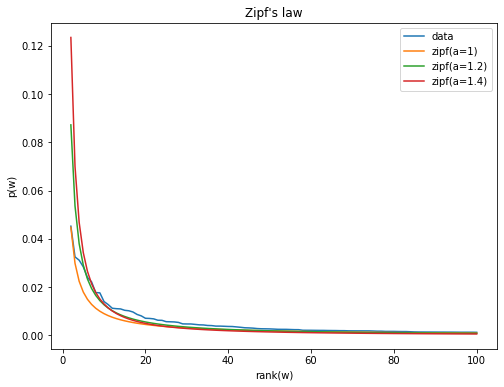

In [62]:
import matplotlib.pyplot as plt
horizontal_points = np.arange(1, len(unifiedvocabulary)+1) # rank
word_frequencies = np.squeeze(unifiedvocabulary_totaloccurrencecounts[highest_totaloccurrences_indices])
vertical_points = word_frequencies / sum(word_frequencies)

a1 = 1
a2 = 1.2
a3 = 1.4
zipf_frequencies1 = np.power(horizontal_points.astype(float), -1 * a1)
zipf_points1 = zipf_frequencies1 / sum(zipf_frequencies1)

zipf_frequencies2 = np.power(horizontal_points.astype(float), -1 * a2)
zipf_points2 = zipf_frequencies2 / sum(zipf_frequencies2)

zipf_frequencies3 = np.power(horizontal_points.astype(float), -1 * a3)
zipf_points3 = zipf_frequencies3 / sum(zipf_frequencies3)

plt.figure(figsize=(8,6))
plt.title('Zipf\'s law')
plt.plot(horizontal_points[1:100], vertical_points[1:100])
plt.plot(horizontal_points[1:100], zipf_points1[1:100])

#plt.plot(horizontal_points[1:100], vertical_points[1:100])
plt.plot(horizontal_points[1:100], zipf_points2[1:100])

#plt.plot(horizontal_points[1:100], vertical_points[1:100])
plt.plot(horizontal_points[1:100], zipf_points3[1:100])

plt.xlabel('rank(w)')
plt.ylabel('p(w)')
plt.legend(['data', 'zipf(a=1)', 'zipf(a=1.2)', 'zipf(a=1.4)'], loc='best')
plt.show() 

a = 1.4 fits best the Zipf's law.